In [4]:
import pandas as pd
import numpy as np
import statsmodels 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Loading the data

In [62]:
file='Index2018.csv'
data=pd.read_csv(file)
print(data.dtypes,'\n',data.shape)
data.head()

date       object
spx       float64
dax       float64
ftse      float64
nikkei    float64
dtype: object 
 (6269, 5)


,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


### Preprocessing

In [63]:
data.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [64]:
data['date']=pd.to_datetime(data['date'],dayfirst=True)
data.set_index('date',inplace=True)
data.asfreq('b').isna().sum()
data.fillna(method='ffill',inplace=True)
mask=data.index.year>=2010
data=data[mask]
data

,spx,dax,ftse,nikkei
date,,,,
2010-01-04,1132.985478,6048.30,5500.340000,10654.79
2010-01-05,1136.523386,6031.86,5522.500000,10681.83
2010-01-06,1137.137830,6034.33,5530.040000,10731.45
2010-01-07,1141.694928,6019.36,5526.720000,10681.66
2010-01-08,1144.983058,6037.61,5534.240000,10798.32
...,...,...,...,...
2018-01-23,2839.130362,13559.60,7731.827774,24124.15
2018-01-24,2837.544008,13414.74,7643.428966,23940.78
2018-01-25,2839.253031,13298.36,7615.839954,23669.49


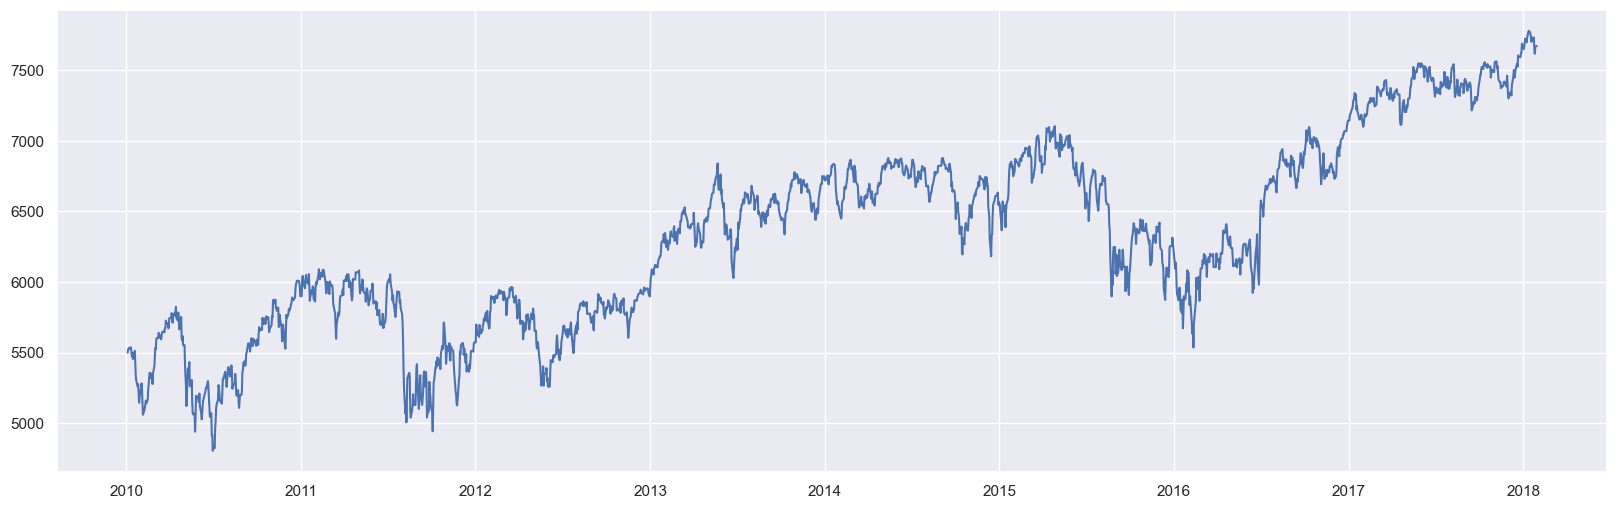

In [66]:
plt.figure(figsize=(20,6))
plt.plot(data.ftse)
plt.show()

In [67]:
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 640x480 with 0 Axes>

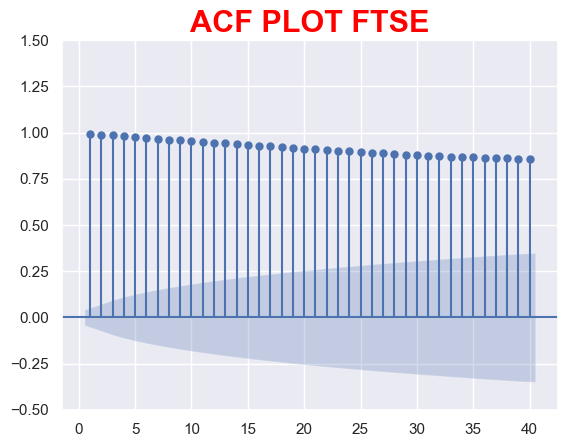

In [68]:
plt.figure()
plot_acf(data.ftse,zero=False,lags=40)
plt.ylim(-1/2,1.5)
plt.title('ACF PLOT FTSE',fontweight='bold',fontsize=22,color='red')
plt.show()

In [69]:
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 640x480 with 0 Axes>

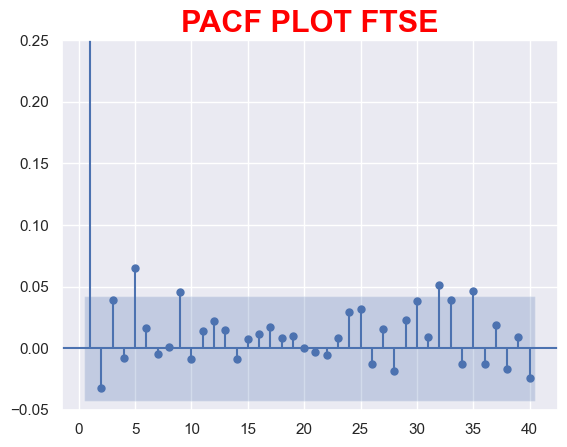

In [70]:
plt.figure()
plot_pacf(data.ftse,zero=False,lags=40,method=('ols'),alpha=0.05)
plt.ylim(-0.05,1/4)
plt.title('PACF PLOT FTSE',fontweight='bold',fontsize=22,color='red')
plt.show()

### Fitting AR model

In [99]:
# Considering the fact that from pacf prev observation has large corr with current it looks tempting to fit AR(1) model
from statsmodels.tsa.arima.model import ARIMA

In [100]:
result=ARIMA(data.ftse,order=(1,0)).fit()

ValueError: `order` argument must be an iterable with three elements.